## IMPORTING PACKAGES

In [1]:
## Import the necessary packages
from bs4 import BeautifulSoup
import urllib
import re
import pandas as pd
import requests
import bs4
from urllib.request import urlopen
import time
import seaborn as sns

## QUESTION 1

In [2]:

def find_jobs(url, counter):
    """
    Fetching the records from the main page of search
    """
    
    main_url ="https://www.indeed.com/m/"
    page = requests.get(url)
    main_soup = bs4.BeautifulSoup(page.text,"html.parser")
    body = main_soup.html.body 

    main_df = pd.DataFrame()
    url_lists=[]
    title_all = []
    company_all = []
    address_all = []
    description_all = []
    urls = []
    
    #Getting link of each job on the first page
    for index,val in enumerate(body.find_all({"h2": {"class": "jobTitle"}})):
        link = val.a["href"]
        new_link=main_url + link
        url_lists.append(new_link)

    #From each individual job of the "first page", getting requisite details like company, title etc 
    for url in url_lists:
        job = requests.get(url)
        urls.append(url)
        soup = bs4.BeautifulSoup(job.text,"html.parser")
        body = soup.html.body
        title= body.p.b.text
        company = body.find_all(id="desc")[0].find_all("span")[0].text 
        address = body.p.span.text
        description = body.find_all(id="desc")[0].text

        title_all.append(title)
        company_all.append(company)
        address_all.append(address)
        description_all.append(description)

    #Creating a pandas dataframe by appending records
    job = {'title': title_all,'company': company_all,'location': address_all,'Job Description': description_all,'PageNo':counter}
    df = pd.DataFrame.from_dict(job)
    main_df = main_df.append(df)
    
    #In case there is no other new_url to go to? Writing a try except for that
    new_url = None
    
    #Finding the link of the "Next" page. For some cities, the search is less than my counter, therefore try & except
    elem = main_soup(text=re.compile(r'Next')) # getting list of all elements with regex match on Next

    # check if every element has href
    for i in elem:
        try:
            i.parent["href"]                  # checking for href
        except KeyError:
            # if it doesn't have href, continue to the next one 
            continue
        else:
            # if you found href here, break the loop and give elem the last value
            elem = i
            break
    
    # if the list is empty it means no next were found
    if not elem:

        print("No next page found for url ", url)
        new_url = None

    else:
        new_url = main_url + elem.parent["href"]
        
    
    return main_df, new_url


In [3]:
def find_jobs_for_city(url):
    """
    Recursive function to extract jobs from multiple pages
    """
    counter = 0
    all_data = pd.DataFrame()

    url = url
    
    #Trying to get 200 jobs for each city
    while counter <= 200:
        
        result = find_jobs(url, counter)
        url = result[1]
        all_data = all_data.append(result[0], ignore_index=True)
        counter += result[0].shape[0]
        
        if url is None:
            break

    #Creating columns for each skill
    skills = ['C','C++','Java','Javascript','Python','R','SQL','Hadoop','Hive','Pig','Spark','AWS','Tableau']
    
    for s in skills:
        all_data[s] = 0
    
    #Calculating the occurence of each skill using REGEX
    for index, row in all_data.iterrows():
    
        match1 = re.findall(r'\b[Pp]ython|python\b', row['Job Description']) 
        if len(match1) > 0:
            all_data.at[index, 'Python'] = 1

        match2 = re.findall(r'\bC\b', row['Job Description']) 
        if len(match2) > 0:
            all_data.at[index, 'C'] = 1

        match3 = re.findall(r'\bC\+\+\b', row['Job Description']) 
        if len(match3) > 0:
            all_data.at[index, 'C++'] = 1

        match4 = re.findall(r'\b[Jj]ava|JAVA\b', row['Job Description']) 
        if len(match4) > 0:
            all_data.at[index, 'Java'] = 1

        match5 = re.findall(r'\b[Jj]avascript|JAVASCRIPT\b', row['Job Description']) 
        if len(match5) > 0:
            all_data.at[index, 'Javascript'] = 1

        match6 = re.findall(r'\bR\b', row['Job Description']) 
        if len(match6) > 0:
            all_data.at[index, 'R'] = 1

        match7 = re.findall(r'\b[sS]ql|SQL\b', row['Job Description']) 
        if len(match7) > 0:
            all_data.at[index, 'SQL'] = 1

        match8 = re.findall(r'\b[Hh]adoop|HADOOP\b', row['Job Description']) 
        if len(match8) > 0:
            all_data.at[index, 'Hadoop'] = 1

        match9 = re.findall(r'\b[hH]ive|HIVE\b', row['Job Description']) 
        if len(match9) > 0:
            all_data.at[index, 'Hive'] = 1

        match10 = re.findall(r'\b[Pp]ig|PIG\b', row['Job Description']) 
        if len(match10) > 0:
            all_data.at[index, 'Pig'] = 1

        match11 = re.findall(r'\b[Ss]park|SPARK\b', row['Job Description']) 
        if len(match11) > 0:
            all_data.at[index, 'Spark'] = 1

        match12 = re.findall(r'\b[Aa]ws|AWS\b', row['Job Description']) 
        if len(match12) > 0:
            all_data.at[index, 'AWS'] = 1

        match13 = re.findall(r'\b[tT]ableau|ABLEAU\b', row['Job Description']) 
        if len(match13) > 0:
            all_data.at[index, 'Tableau'] = 1
    
    #Creating the summary table that will go as a value item inteh cities dictionary, corresponding to each city
    summary = {'Python': sum(all_data["Python"]),
           'C': sum(all_data["C"]),
           'Cplus2': sum(all_data["C++"]),
           'Java': sum(all_data["Java"]),
           'Javascript':sum(all_data["Javascript"]),
           'R':sum(all_data["R"]),
           'SQL':sum(all_data["SQL"]),
           'Hadoop':sum(all_data["Hadoop"]),
           'Hive':sum(all_data["Hive"]),
           'Pig':sum(all_data["Pig"]),
           'Spark':sum(all_data["Spark"]),
           'AWS':sum(all_data["AWS"]),
           'Tableau':sum(all_data["Tableau"]),
          }
    summary = pd.DataFrame(summary,index=[0]) 
    
    return all_data, summary

In [4]:
cities = {
    "Los+Angeles": None,
    "San+Fransisco": None,
    "New+York" :None,
    "Boston":None,
    "Chicago":None,
    "Austin":None,
    "Washington+DC" :None
}


for city in cities.keys(): 
    """
    Single function to find jobs for each city in a loop
    """
    url = "https://www.indeed.com/m/jobs?q=data+scientist&l=" + city
    start_time = time.time()
    print("Starting city ", city)
    
    all_data, summary = find_jobs_for_city(url)

    cities[city] = {"jobs": all_data, "summary": summary}
    
    end_time = time.time()
    total_time = end_time-start_time
    print("Total Time Taken: ", total_time, "No of jobs: ", cities[city]["jobs"].shape[0])

Starting city  Los+Angeles
Total Time Taken:  31.426130771636963 No of jobs:  210
Starting city  San+Fransisco
Total Time Taken:  31.119965076446533 No of jobs:  210
Starting city  New+York
Total Time Taken:  33.02478814125061 No of jobs:  210
Starting city  Boston
Total Time Taken:  33.686832904815674 No of jobs:  210
Starting city  Chicago
Total Time Taken:  32.31613302230835 No of jobs:  210
Starting city  Austin
No next page found for url  https://www.indeed.com/m/viewjob?jk=04390297b5591a67
Total Time Taken:  29.316571950912476 No of jobs:  180
Starting city  Washington+DC
Total Time Taken:  34.50042486190796 No of jobs:  210


In [10]:
cities.keys()

dict_keys(['Los+Angeles', 'San+Fransisco', 'New+York', 'Boston', 'Chicago', 'Austin', 'Washington+DC'])

## Question 1 & Bonus Question: Comparison of Skills across different cities

In [5]:
LA= cities['Los+Angeles']
LA['city'] = "LA"

SF= cities['San+Fransisco']
SF['city'] = " SF"

NYC= cities['New+York']
NYC['city'] = "NYC"

BOSTON= cities['Boston']
BOSTON['city'] = "BOSTON"

CHICAGO= cities['Chicago']
CHICAGO['city'] = "Chicago"

AUSTIN= cities['Austin']
AUSTIN['city'] = "Austin"

DC= cities['Washington+DC']
DC['city'] = "DC"

In [15]:
all_cities_summary = pd.DataFrame()
all_cities_jobs = pd.DataFrame()

# LA = {"city": "LA", "jobs": df, "summary": df}

for data_dict in [LA, SF, NYC, BOSTON, CHICAGO, AUSTIN, DC]:
    
    city_skill_summary = data_dict['summary']
    city_skill_summary['City'] = data_dict['city']
    all_cities_summary = all_cities_summary.append(city_skill_summary, ignore_index=True)
    
    # add another column to the individually appending data frame that is the name of the city
    city_all_jobs = data_dict['jobs']
    city_all_jobs['City'] = data_dict['city']
    all_cities_jobs = all_cities_jobs.append(city_all_jobs, ignore_index=True)

In [14]:
all_cities_summary

,Python,C,Cplus2,Java,Javascript,R,SQL,Hadoop,Hive,Pig,Spark,AWS,Tableau,City
0,151,39,1,51,5,108,120,31,13,1,41,30,53,LA
1,160,23,0,31,3,102,124,37,33,8,52,22,37,SF
2,174,20,1,60,10,123,125,38,22,5,49,23,41,NYC
3,146,35,1,37,2,105,94,28,17,3,37,30,34,BOSTON
4,149,34,3,34,2,125,100,47,21,7,45,42,39,Chicago
5,121,50,5,58,5,78,93,25,22,5,57,27,37,Austin
6,134,44,1,44,3,109,98,18,10,9,28,34,55,DC


In [16]:
all_cities_jobs

,title,company,location,Job Description,PageNo,C,C++,Java,Javascript,Python,R,SQL,Hadoop,Hive,Pig,Spark,AWS,Tableau,City
0,Data Scientist,Deloitte,"Los Angeles, CA 90013",Deloitte Services LP includes internal support...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,LA
1,Data Scientist,AvantStay,"Los Angeles, CA","Who we are...\nAvantStay delivers exceptional,...",0,0,0,0,0,1,1,1,0,0,0,0,0,0,LA
2,Data Scientist I - (Part-time),"Columbus Technologies and Services, Inc.","Pasadena, CA 91101",Must be a US Citizen\nEstimated duration of 12...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,LA
3,Data Scientist,Age of Learning,"Glendale, CA 91203",Company Overview:\nAge of Learning is a leadin...,0,0,0,0,0,1,1,1,0,0,0,0,0,1,LA
4,Data Scientist,30+ days ago,"Pasadena, CA 91101",Data ScientistQualificationsMajor in quantitat...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,LA
5,Data Scientist/Visualization Master,InterMedia Advertising,"Los Angeles, CA 90067",We are seeking a Manager of Business Intellige...,0,0,0,0,0,0,1,1,0,0,0,0,0,1,LA
6,Data Scientist,GOAT,"Los Angeles, CA","With over 20 million members, GOAT is the worl...",0,0,0,0,0,1,1,0,0,0,0,0,0,0,LA
7,Data Scientist,NBCUniversal,"Beverly Hills, CA","Fandango is seeking a driven, analytically cur...",0,0,0,0,0,1,1,1,0,0,0,0,0,1,LA
8,Data Scientist/Analyst,2 days ago,"Long Beach, CA",Required Qualifications-NLP exp must5-10 years...,0,0,0,0,0,0,1,1,1,1,0,0,0,0,LA
9,Data Scientist - Risk Management,LoanMart,"Van Nuys, CA 91406","ABOUT US: Wheels Financial Group, LLC d/b/a Lo...",0,0,0,0,0,1,1,1,0,0,0,0,0,0,LA


In [55]:
all_cities_jobs[['title','company','location','Job Description','City']]

,title,company,location,Job Description,City
0,Data Scientist,Deloitte,"Los Angeles, CA 90013",Deloitte Services LP includes internal support...,LA
1,Data Scientist,AvantStay,"Los Angeles, CA","Who we are...\nAvantStay delivers exceptional,...",LA
2,Data Scientist I - (Part-time),"Columbus Technologies and Services, Inc.","Pasadena, CA 91101",Must be a US Citizen\nEstimated duration of 12...,LA
3,Data Scientist,Age of Learning,"Glendale, CA 91203",Company Overview:\nAge of Learning is a leadin...,LA
4,Data Scientist,30+ days ago,"Pasadena, CA 91101",Data ScientistQualificationsMajor in quantitat...,LA
5,Data Scientist/Visualization Master,InterMedia Advertising,"Los Angeles, CA 90067",We are seeking a Manager of Business Intellige...,LA
6,Data Scientist,GOAT,"Los Angeles, CA","With over 20 million members, GOAT is the worl...",LA
7,Data Scientist,NBCUniversal,"Beverly Hills, CA","Fandango is seeking a driven, analytically cur...",LA
8,Data Scientist/Analyst,2 days ago,"Long Beach, CA",Required Qualifications-NLP exp must5-10 years...,LA
9,Data Scientist - Risk Management,LoanMart,"Van Nuys, CA 91406","ABOUT US: Wheels Financial Group, LLC d/b/a Lo...",LA


In [17]:
all_cities_jobs.to_csv("all_cities_jobs.csv")

## VISUALIZATION

In [18]:
sns.set(style="whitegrid")

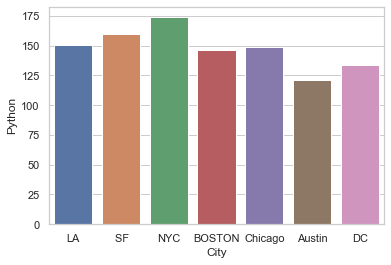

In [38]:
#Distribution of Python Skill across cities

ax = sns.barplot(x="City", y="Python", data=all_cities_summary)

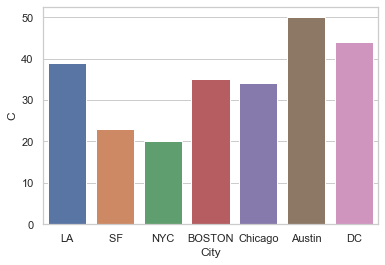

In [39]:
#Distribution of C Skill across cities

ax = sns.barplot(x="City", y="C", data=all_cities_summary)

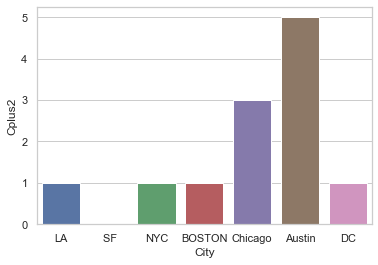

In [43]:
#Distribution of C++ Skill across cities

ax = sns.barplot(x="City", y="Cplus2", data=all_cities_summary)

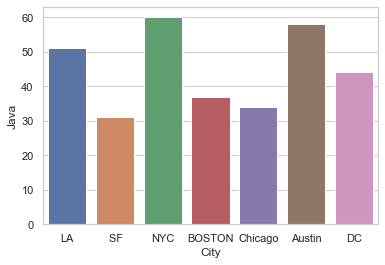

In [44]:
#Distribution of Java Skill across cities
ax = sns.barplot(x="City", y="Java", data=all_cities_summary)

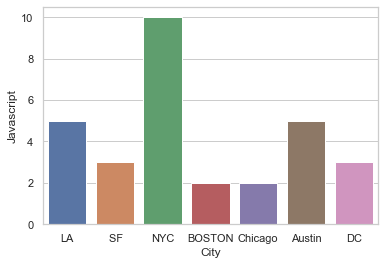

In [45]:
#Distribution of Javascript Skill across cities

ax = sns.barplot(x="City", y="Javascript", data=all_cities_summary)

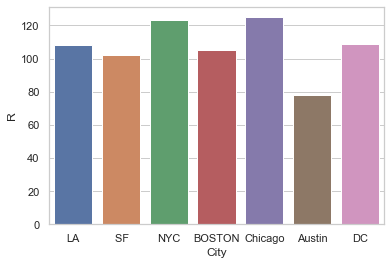

In [46]:
#Distribution of R Skill across cities

ax = sns.barplot(x="City", y="R", data=all_cities_summary)

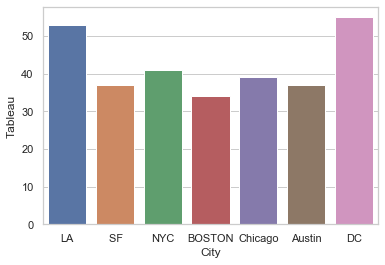

In [47]:
#Distribution of Tableau Skill across cities

ax = sns.barplot(x="City", y="Tableau", data=all_cities_summary)

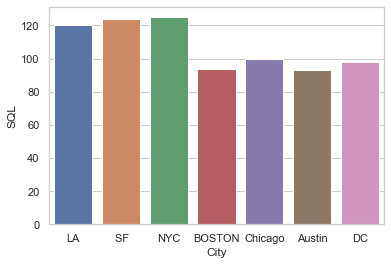

In [48]:
#Distribution of SQL Skill across cities

ax = sns.barplot(x="City", y="SQL", data=all_cities_summary)

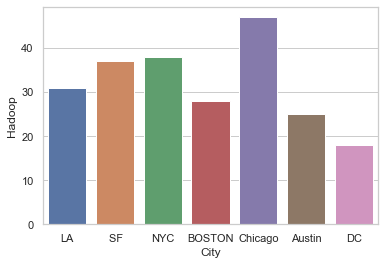

In [49]:
#Distribution of Hadoop Skill across cities

ax = sns.barplot(x="City", y="Hadoop", data=all_cities_summary)

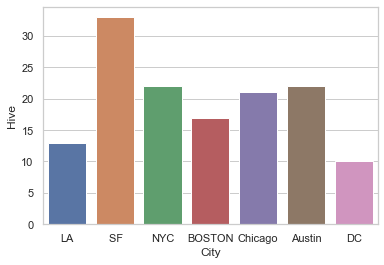

In [50]:
#Distribution of Hive Skill across cities

ax = sns.barplot(x="City", y="Hive", data=all_cities_summary)

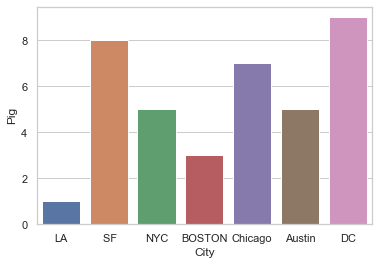

In [51]:
#Distribution of Pig Skill across cities

ax = sns.barplot(x="City", y="Pig", data=all_cities_summary)

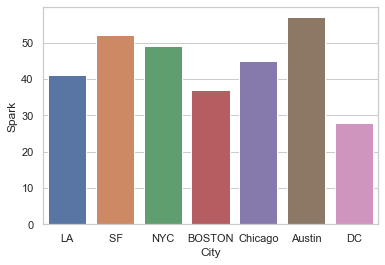

In [52]:
#Distribution of Spark Skill across cities

ax = sns.barplot(x="City", y="Spark", data=all_cities_summary)

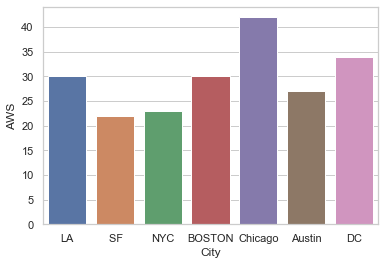

In [53]:
#Distribution of AWS Skill across cities

ax = sns.barplot(x="City", y="AWS", data=all_cities_summary)